In [221]:
# 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import requests, json

### WPDX RESTAPI를 이용해 데이터를 읽어온다.

- 보안상의 이슈로 local 환경에서 진행한다.
- 도메인을 내기엔 cost가 너무 비싸다는 결론

In [264]:
result = requests.get("http://localhost:3000/api/dx/23_middle_student") # WPDX RESTAPI를 이용해 데이터를 읽어온다.

rows = json.loads(result.text)["rows"]
df = pd.DataFrame(rows)

df.head()

,UID,CenterId,StudentName,SchoolName,SchoolGrade,SchoolLevel,StudentGrade,Address,Address2,StudentStatus,cs_count,max_sche_date,withdraw_csl_count,remain_csl_count,supply_count,clinic_count,abs_count,pre_count,target
0,00249736-53A0-4D68-8CB9-DFA306A33435,15,임현승,성동중학교,1학년,high,17,None,None,drop,5,2023-11-17,0,3,0,0,1,41,0
1,00515C99-00A6-444B-93A3-73D7BB0852E5,15,노해율,내성중학교,3학년,middle,16,부산 동래구 금정마을로 135-9(동래 래미안 아이파크),2단지-5호차,present,5,2023-07-20,0,19,0,0,0,52,0
2,00600FC7-C7DE-40DE-AD7D-A1D94DD5D212,16,신아인,경일중학교,3학년,middle,16,부산 강서구 명지국제7로 110(더 힐 시그니처),None,present,8,2024-02-15,0,0,0,0,0,0,1
3,0063DEBD-095C-4804-A246-7EDD5160419A,14,손태윤,브니엘예술중학교,3학년,middle,16,None,None,drop,2,2023-10-01,0,0,0,0,0,6,0
4,007378EC-9A44-4A75-8B1A-70D13FBE7832,16,오주안,오션중학교,3학년,middle,16,None,명지 오션 11로 87,present,29,2024-02-15,0,23,0,0,1,278,1


### 학습 할 데이터(X)의 필요없는 필드 정리

In [265]:
X=df[df.columns[6:]]
X = X.drop(columns = ['Address','Address2', 'max_sche_date', 'StudentStatus'])

X.head()

,StudentGrade,cs_count,withdraw_csl_count,remain_csl_count,supply_count,clinic_count,abs_count,pre_count,target
0,17,5,0,3,0,0,1,41,0
1,16,5,0,19,0,0,0,52,0
2,16,8,0,0,0,0,0,0,1
3,16,2,0,0,0,0,0,6,0
4,16,29,0,23,0,0,1,278,1


### 학습을 진행할 데이터(X) 정규화
- StudentGrade의 데이터 값들을 0, 1, 2로 치환한다.

In [266]:
print(X['StudentGrade'].unique())
X['StudentGrade'].replace({15: 0, 16: 1, 17:2}, inplace=True)
X

[17 16 15]


,StudentGrade,cs_count,withdraw_csl_count,remain_csl_count,supply_count,clinic_count,abs_count,pre_count,target
0,2,5,0,3,0,0,1,41,0
1,1,5,0,19,0,0,0,52,0
2,1,8,0,0,0,0,0,0,1
3,1,2,0,0,0,0,0,6,0
4,1,29,0,23,0,0,1,278,1
...,...,...,...,...,...,...,...,...,...
2492,0,2,1,20,0,0,0,64,1
2493,1,9,0,0,0,0,0,0,1
2494,1,3,1,9,0,0,0,23,0
2495,2,6,0,0,0,0,0,0,1


In [267]:
pd.DataFrame(X).describe()

,StudentGrade,cs_count,withdraw_csl_count,remain_csl_count,supply_count,clinic_count,abs_count,pre_count,target
count,2497.000000,2497.000000,2497.000000,2497.000000,2497.000000,2497.000000,2497.000000,2497.000000,2497.000000
mean,1.080497,10.095715,0.236684,8.060473,0.010813,0.028835,2.785342,64.474169,0.567080
std,0.822076,10.497140,0.648321,9.690521,0.130807,0.447538,5.310735,80.639647,0.495579
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000
50%,1.000000,6.000000,0.000000,4.000000,0.000000,0.000000,0.000000,31.000000,1.000000
75%,2.000000,14.000000,0.000000,13.000000,0.000000,0.000000,3.000000,95.000000,1.000000
max,2.000000,62.000000,19.000000,64.000000,2.000000,11.000000,54.000000,396.000000,1.000000


### 우선 boxplot을 이용해 눈에 띄는(값의 분포가 큰) 데이터를 확인해보자!
- pre_count의 value 분포가 가장 큰 것을 확인할 수 있다.

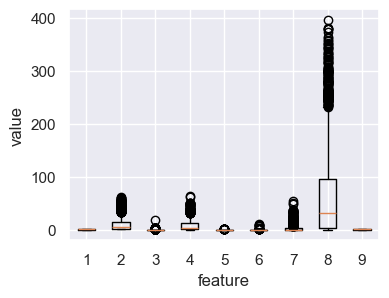

Index(['pre_count'], dtype='object')


In [268]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
plt.boxplot(X)
plt.xlabel('feature')
plt.ylabel('value')

plt.show()

print(X.columns[[7]])

### Target 데이터의 비율을 확인해보자
- 비율이 대략 56:43 인 것을 확인할 수 있다.

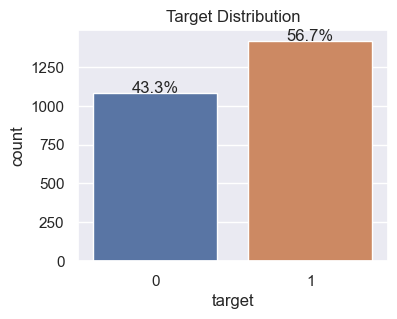

In [272]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib inline  # notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것
plt.rc('font', family='NanumGothic') # For Windows

def write_percent(ax, total_size):
    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()
        percent = height/total_size*100

        ax.text(x=left_coord+width/2.0,
                y=height + total_size * 0.001,
                s=f'{percent:1.1f}%',
                ha='center')

plt.figure(figsize=(4, 3))
mpl.rc('font', size=15)
sns.set_theme(style='darkgrid')
ax = sns.countplot(x="target", data=X)
ax.set_title('Target Distribution')

write_percent(ax, (X.shape[0]))
plt.show()

### scatter를 이용해 features들간의 상관관계를 측정해보자.
- 데이터가 매우 난잡하고, 정규화(표준화)가 되어있지 않아, 보기 난해하다.
- 이후에 데이터를 잘 정돈하여 학습을 진행하고, Features들간의 관계를 측정해보면 좋을 듯하다.

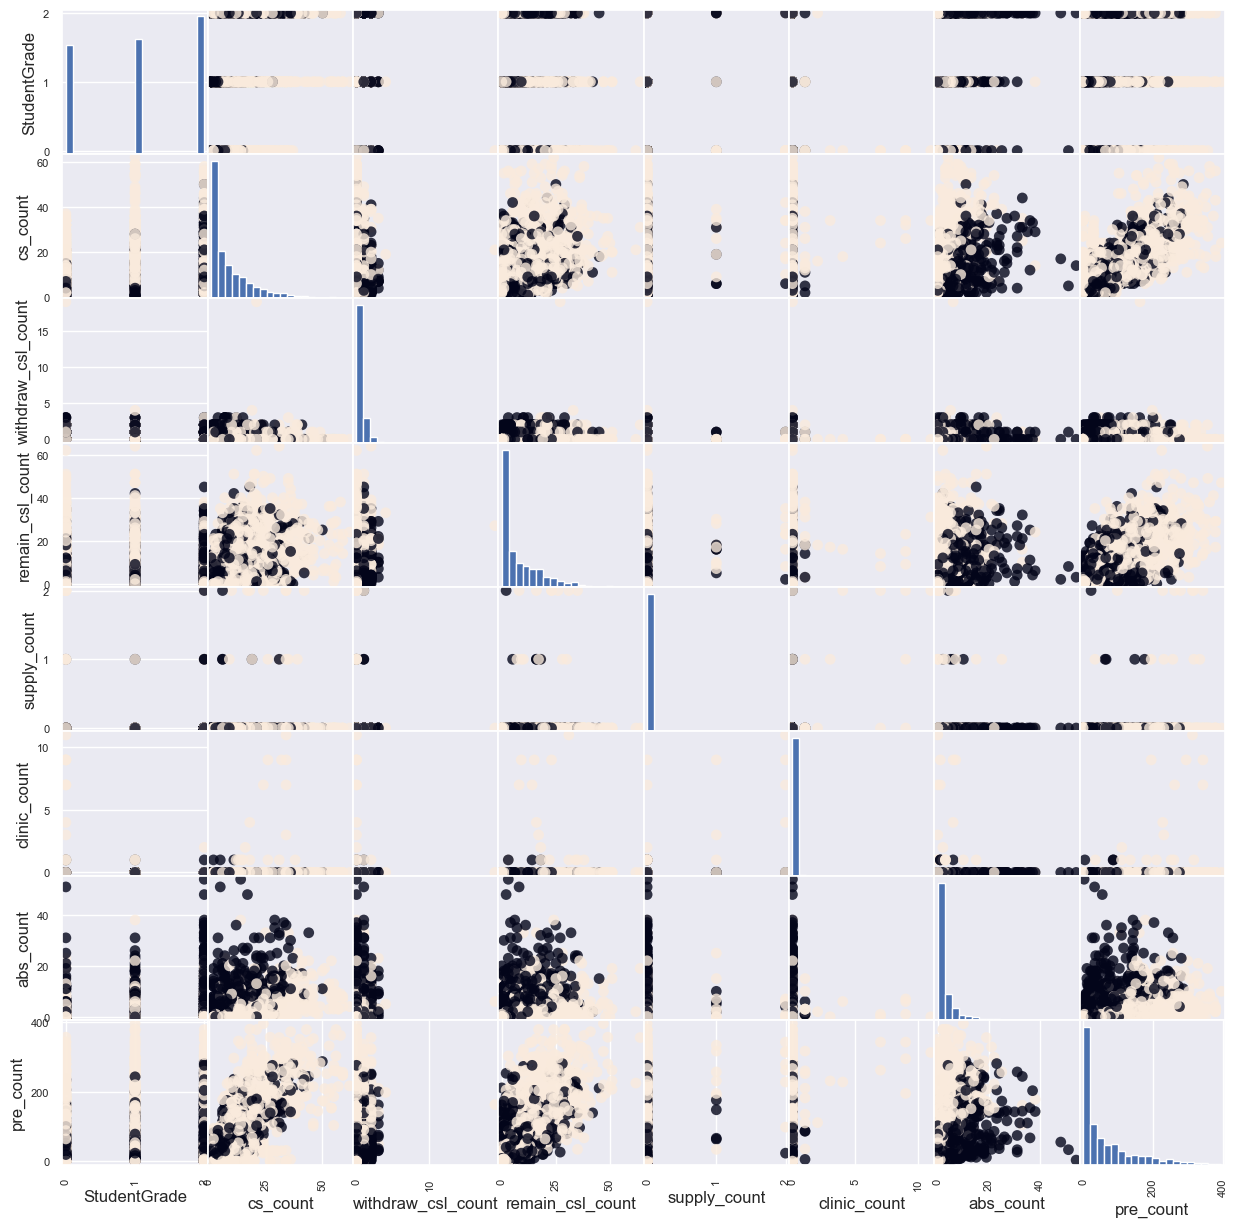

In [274]:
x_df = pd.DataFrame(X, columns=X.columns[:-1])
x_df
pd.plotting.scatter_matrix(x_df, c=X['target'], figsize=(15,15),
                           marker='o', hist_kwds={'bins':20}, s=60, alpha=.8)

                           # marker: 동그라미
                           # his_kwds: 히스토그램 키워드
                           # s: 마커 사이즈
                           # c: 마커 컬러
                           # alpha: 투명도
plt.show()


In [277]:
# 피어슨의 상관대수
X.corr(method='pearson')

,StudentGrade,cs_count,withdraw_csl_count,remain_csl_count,supply_count,clinic_count,abs_count,pre_count,target
StudentGrade,1.000000,0.142799,-0.076354,-0.140171,-0.034178,-0.073827,0.198415,0.006833,-0.183879
cs_count,0.142799,1.000000,-0.006921,0.488435,0.102827,0.108487,0.414582,0.759816,0.244171
withdraw_csl_count,-0.076354,-0.006921,1.000000,0.167158,0.007604,-0.018008,0.144505,0.104993,-0.202188
remain_csl_count,-0.140171,0.488435,0.167158,1.000000,0.089878,0.066851,0.307110,0.763087,0.119662
supply_count,-0.034178,0.102827,0.007604,0.089878,1.000000,0.507952,0.033332,0.151668,0.035159
clinic_count,-0.073827,0.108487,-0.018008,0.066851,0.507952,1.000000,0.000751,0.155851,0.050887
abs_count,0.198415,0.414582,0.144505,0.307110,0.033332,0.000751,1.000000,0.383983,-0.222561
pre_count,0.006833,0.759816,0.104993,0.763087,0.151668,0.155851,0.383983,1.000000,0.145161
target,-0.183879,0.244171,-0.202188,0.119662,0.035159,0.050887,-0.222561,0.145161,1.000000


## 이상치 갖는 샘플 드랍 (2) : percentile
- 각각의 컬럼에 대해 하나라도 이상치가 있을 경우 드랍

In [226]:
import pandas as pd

# 이상치를 판별하고자 하는 컬럼 리스트
target_columns = ['cs_count', 'withdraw_csl_count', 'remain_csl_count', 'supply_count', 'clinic_count', 'abs_count', 'pre_count']

# 이상치를 제거할 함수 정의 (1) percentile
def remove_outliers_percentile(df, column):
    lower_bound = df[column].quantile(0.05)  # 하위 5%에 해당하는 값은 이상치로 간주
    upper_bound = df[column].quantile(0.95)  # 상위 95%에 해당하는 값은 이상치로 간주
    cleaned_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    outliers_removed = len(df) - len(cleaned_df)
    return cleaned_df, outliers_removed

# 이상치를 제거할 함수 정의 (2) 표준편차
def remove_outliers_std(df, column):
    mean_value = df[column].mean()
    std_dev = df[column].std()
    lower_bound = mean_value - 3 * std_dev  # 평균에서 3표준편차 미만인 값은 이상치로 간주
    upper_bound = mean_value + 3 * std_dev  # 평균에서 3표준편차 초과인 값은 이상치로 간주
    cleaned_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    outliers_removed = len(df) - len(cleaned_df)
    return cleaned_df, outliers_removed

# 이상치 제거 함수 호출
outliers_removed_total = 0
for column in target_columns:
    #cleaned_df, outliers_removed = remove_outliers_percentile(X, column)  # 백분위수를 사용하는 경우
    cleaned_df, outliers_removed = remove_outliers_std(X, column)  # 표준편차를 사용하는 경우
    outliers_removed_total += outliers_removed
    print(f"{column} 컬럼에서 이상치 제거된 샘플 수:", outliers_removed)
    X = cleaned_df  
  
print("총 이상치 제거된 샘플 수:", outliers_removed_total)

cs_count 컬럼에서 이상치 제거된 샘플 수: 51
withdraw_csl_count 컬럼에서 이상치 제거된 샘플 수: 14
remain_csl_count 컬럼에서 이상치 제거된 샘플 수: 37
supply_count 컬럼에서 이상치 제거된 샘플 수: 18
clinic_count 컬럼에서 이상치 제거된 샘플 수: 12
abs_count 컬럼에서 이상치 제거된 샘플 수: 58
pre_count 컬럼에서 이상치 제거된 샘플 수: 45
총 이상치 제거된 샘플 수: 235


In [227]:
# 남은 샘플을 0과 1로 변환하는 코드

'''
for column in target_columns:
    mean_value = X[column].mean()
    X[column] = (X[column] > mean_value).astype(int)

X
'''

'\nfor column in target_columns:\n    mean_value = X[column].mean()\n    X[column] = (X[column] > mean_value).astype(int)\n\nX\n'

In [228]:
# 예측 할 데이터 설정
y = X['target']
X = X.drop(columns = ['target'])

y # 0과 1로 구분, 1:재원 / 0:퇴원

0       0
1       0
2       1
3       0
5       0
       ..
2492    1
2493    1
2494    0
2495    1
2496    0
Name: target, Length: 2262, dtype: int64

### 인공지능 학습을 위한 학습 데이터와 검증용 데이터 분리
- Train/Test set 분리
- Train/Validation/Test set 분리

In [229]:
# Train/Test set 분리

from sklearn.model_selection import train_test_split

X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 0)

In [230]:
X_tmp.shape, X_test.shape, y_tmp.shape, y_test.shape

((1809, 8), (453, 8), (1809,), (453,))

In [231]:
# Train/Validation/Test set 분리 (6:2:2)

X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.25, stratify=y_tmp, random_state=0)

In [232]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1356, 8), (453, 8), (453, 8), (1356,), (453,), (453,))

In [233]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler_minmax=MinMaxScaler()
scaler_standard=StandardScaler()

### 학습할 데이터 정규화
- 3번의 데이터 정규화를 거친다. 이때 사용하는 Scaler는 MinMaxScaler 혹은 StandardScaler


In [234]:
scaler_standard.fit(X_train)
X_scaled_standard_train=scaler_standard.transform(X_train)
pd.DataFrame(X_scaled_standard_train).describe()

,0,1,2,3,4,5,6,7
count,1.356000e+03,1.356000e+03,1.356000e+03,1.356000e+03,1356.0,1356.0,1.356000e+03,1.356000e+03
mean,2.619995e-17,9.431983e-17,-1.047998e-17,4.453992e-17,0.0,0.0,1.702997e-17,-1.440997e-17
std,1.000369e+00,1.000369e+00,1.000369e+00,1.000369e+00,0.0,0.0,1.000369e+00,1.000369e+00
min,-1.308567e+00,-9.180313e-01,-4.256862e-01,-8.330445e-01,0.0,0.0,-5.808847e-01,-8.200905e-01
25%,-1.308567e+00,-7.887499e-01,-4.256862e-01,-8.330445e-01,0.0,0.0,-5.808847e-01,-7.866963e-01
50%,-9.321302e-02,-4.009058e-01,-4.256862e-01,-4.486060e-01,0.0,0.0,-5.808847e-01,-4.193604e-01
75%,1.122141e+00,4.071029e-01,-4.256862e-01,4.484170e-01,0.0,0.0,3.128517e-01,5.323736e-01
max,1.122141e+00,4.253224e+00,3.653681e+00,3.780217e+00,0.0,0.0,4.483622e+00,3.587940e+00


### 검증 데이터의 정규화

In [235]:
scaler_standard.fit(X_val)
X_scaled_standard_val=scaler_standard.transform(X_val)
pd.DataFrame(X_scaled_standard_val).describe()

,0,1,2,3,4,5,6,7
count,4.530000e+02,4.530000e+02,4.530000e+02,4.530000e+02,453.0,453.0,4.530000e+02,4.530000e+02
mean,-1.960659e-18,-2.352791e-17,-1.568527e-17,-5.881976e-17,0.0,0.0,1.960659e-17,-1.960659e-18
std,1.001106e+00,1.001106e+00,1.001106e+00,1.001106e+00,0.0,0.0,1.001106e+00,1.001106e+00
min,-1.280018e+00,-9.328144e-01,-4.289571e-01,-8.373838e-01,0.0,0.0,-5.841084e-01,-8.057277e-01
25%,-1.280018e+00,-8.079798e-01,-4.289571e-01,-7.245873e-01,0.0,0.0,-5.841084e-01,-7.449485e-01
50%,-9.906454e-02,-4.334762e-01,-4.289571e-01,-3.861975e-01,0.0,0.0,-5.841084e-01,-3.954677e-01
75%,1.081889e+00,5.652001e-01,-4.289571e-01,5.161750e-01,0.0,0.0,3.124301e-02,4.402471e-01
max,1.081889e+00,3.810898e+00,3.987351e+00,3.223293e+00,0.0,0.0,4.646379e+00,3.160119e+00


### 테스트 데이터의 정규화

In [236]:
X_scaled_standard_test=scaler_standard.transform(X_test)
pd.DataFrame(X_scaled_standard_test).describe()

,0,1,2,3,4,5,6,7
count,453.000000,453.000000,453.000000,453.000000,453.0,453.0,453.000000,453.000000
mean,-0.054746,-0.036927,0.082867,-0.116283,0.0,0.0,-0.025809,-0.083387
std,0.956258,0.951724,1.092597,0.904772,0.0,0.0,0.992818,0.944817
min,-1.280018,-0.932814,-0.428957,-0.837384,0.0,0.0,-0.584108,-0.805728
25%,-1.280018,-0.807980,-0.428957,-0.837384,0.0,0.0,-0.584108,-0.790533
50%,-0.099065,-0.433476,-0.428957,-0.498994,0.0,0.0,-0.584108,-0.501831
75%,1.081889,0.440366,-0.428957,0.290582,0.0,0.0,0.031243,0.273104
max,1.081889,4.060567,3.987351,3.223293,0.0,0.0,4.646379,3.220898


### 인공신경망 모델링

In [237]:
model = Sequential([
    Dense(64, activation='relu',input_shape=(X_train.shape[1],)),
    #Dropout(0.3),
    Dense(128, activation='relu'),
    #Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [238]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()
# loss : 출력 값이 두개인 이진 분류에서 사용 / 모델의 마지막 레이어의 활성화 함수는 시그모이드 함수 사용 
# accuracy : 모델의 정확도 출력 / 분류 문제의 인공지능 모델에서 사용

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                576       
                                                                 
 dense_25 (Dense)            (None, 128)               8320      
                                                                 
 dense_26 (Dense)            (None, 32)                4128      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13057 (51.00 KB)
Trainable params: 13057 (51.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습 및 측정

In [239]:
hist = model.fit(X_scaled_standard_train, y_train, validation_data=(X_scaled_standard_val, y_val), epochs=25, batch_size=32)

Epoch 1/25
43/43 [==============================] - 1s 6ms/step - loss: 0.5808 - accuracy: 0.7065 - val_loss: 0.4928 - val_accuracy: 0.7528
Epoch 2/25
43/43 [==============================] - 0s 2ms/step - loss: 0.4786 - accuracy: 0.7662 - val_loss: 0.4570 - val_accuracy: 0.7770
Epoch 3/25
43/43 [==============================] - 0s 2ms/step - loss: 0.4413 - accuracy: 0.7861 - val_loss: 0.4250 - val_accuracy: 0.7991
Epoch 4/25
43/43 [==============================] - 0s 2ms/step - loss: 0.4297 - accuracy: 0.7869 - val_loss: 0.4115 - val_accuracy: 0.8300
Epoch 5/25
43/43 [==============================] - 0s 2ms/step - loss: 0.4209 - accuracy: 0.8024 - val_loss: 0.4264 - val_accuracy: 0.7925
Epoch 6/25
43/43 [==============================] - 0s 2ms/step - loss: 0.4167 - accuracy: 0.8046 - val_loss: 0.4042 - val_accuracy: 0.8168
Epoch 7/25
43/43 [==============================] - 0s 2ms/step - loss: 0.4090 - accuracy: 0.8083 - val_loss: 0.4063 - val_accuracy: 0.8212
Epoch 8/25
43/43 [==

### 모델 평가

In [240]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

15/15 [==============================] - 0s 1ms/step - loss: 22.8424 - accuracy: 0.5784
Test Accuracy: 0.5783664584159851


In [241]:
y_pred = model.predict(X_test)
y_pred = (y_pred>0.5).astype(int)

y_pred

15/15 [==============================] - 0s 1ms/step


array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
    

### 09. 결과 지표 (컨퓨전 매트릭스)

In [242]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(y_test, y_pred)

array([[ 24, 177],
       [ 14, 238]], dtype=int64)

In [243]:
# Accuracy = (TP + TN) / (TP + TN + FP + FN) 수동 정확도 계산
cm = confusion_matrix(y_test, y_pred)
(129+234) / cm.sum()

0.8013245033112583

In [244]:
history_dict = hist.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

C:\Users\wogus\AppData\Local\Temp\ipykernel_17792\35841116.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', c='red')


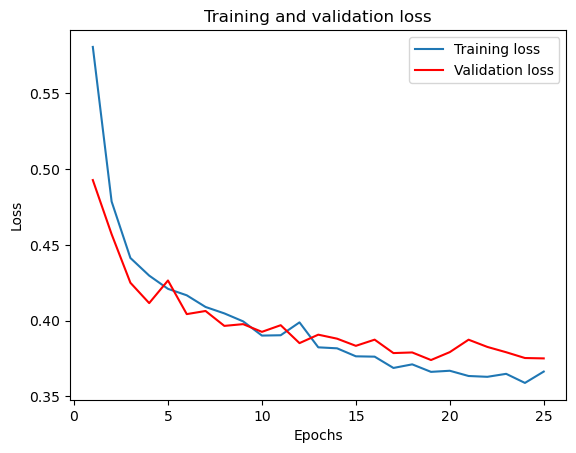

In [245]:
# 훈련과 검증 손실 그리기
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss', c='red')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

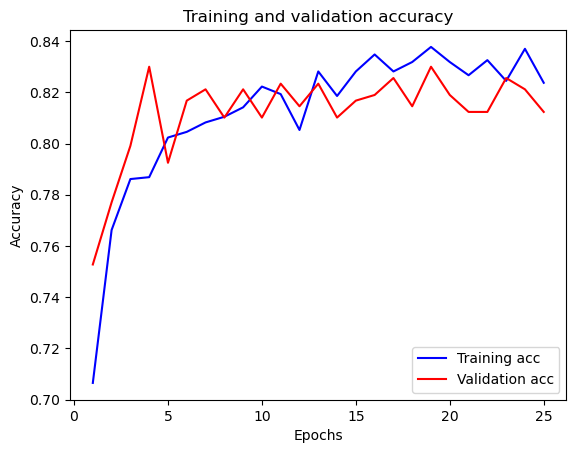

In [246]:
# 훈련과 검증 정확도 그리기
plt.clf()   # 그래프를 초기화합니다

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, label='Training acc', c='blue')
plt.plot(epochs, val_acc, label='Validation acc', c='red')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [247]:
model.layers

In [248]:
hidden_1 = model.layers[0]
hidden_1.name

'dense_24'

In [249]:
weights1, biases1 = hidden_1.get_weights()
print(weights1.shape)
print(biases1.shape)

(8, 64)
(64,)


In [250]:
print(weights1)

[[-0.26667136 -0.17015281  0.37886438  0.14148596 -0.16272347  0.21013974
  -0.23213756  0.1769421  -0.28199884 -0.01027407  0.13401078 -0.22230774
   0.29801887  0.1845573  -0.21879381 -0.28600332 -0.00326477  0.12260588
   0.2616421  -0.20233226 -0.2712224   0.25652778  0.05335419  0.2073994
   0.25539538 -0.00458523 -0.26087108  0.27686557 -0.17476726 -0.3042764
   0.02920927  0.28741762 -0.18875737 -0.11208551 -0.21045753  0.00289578
  -0.01033989 -0.22001086  0.17813994 -0.19542     0.23768099 -0.24993138
   0.1626529  -0.06841613  0.31018484 -0.21096689 -0.34460992 -0.18064553
   0.1869717  -0.24281655 -0.06074332 -0.17589149 -0.00398625 -0.01681951
   0.136519    0.22900322 -0.04453788 -0.24715027  0.04834808  0.04387217
  -0.254788    0.27079582  0.19008632  0.21354449]
 [ 0.29107624 -0.11808775  0.2235213   0.26657394 -0.12559627  0.08678514
   0.06191709 -0.11610347  0.2265243   0.16829969 -0.03802045  0.03067749
  -0.04126557  0.27800256 -0.00435695  0.0655659   0.21070066  

In [251]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


### 1) SHAP (SHapley Additive exPlanations)
- x축에는 SHAP 값의 평균이 표시됩니다. 양수 값은 해당 특성이 예측을 높이는 데 기여하지만, 음수 값은 예측을 낮추는 데 기여한다는 것을 의미합니다.
- 가장 중요한 특성은 x축에서 가장 먼 위치에 있는 특성입니다. 즉, SHAP 값이 큰 특성은 해당 모델에서 가장 중요한 특성으로 간주될 수 있습니다.
- 플롯의 색상은 각 특성의 실제 값에 대한 정보를 제공합니다. 높은 값은 더 진한 색상으로 표시되고, 낮은 값은 더 밝은 색상으로 표시됩니다.
- 이를 통해 각 특성의 값이 예측에 어떻게 영향을 미치는지를 시각적으로 확인할 수 있습니다.

In [252]:
import shap

# SHAP 설명자 생성
explainer = shap.Explainer(model, X_train)

# SHAP 값 계산
shap_values = explainer.shap_values(X_test)

# SHAP 요약 플롯
shap.summary_plot(shap_values, X_test, plot_size=(3, 3),  max_display=X_test.shape[1])

AttributeError: 'ExactExplainer' object has no attribute 'shap_values'

In [ ]:
tree_explainer = shap.TreeExplainer(model) ## TreeExplainer 객체 생성
shap_values = tree_explainer.shap_values(X_train) ## SHAP Value
feature_names = X_train.columns  ## 변수명
 
## 변수 중요도
for i in range(X_train.shape[1]):
    feature_imp = np.mean(np.abs(shap_values[:, i]))
    print(f'{feature_names[i]}의 중요도 :', feature_imp)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 각 특성의 중요도 값
importance_values = [np.mean(np.abs(shap_values[:, i])) for i in range(X_train.shape[1])]

# 특성 이름
feature_names = X_train.columns

# 중요도를 내림차순으로 정렬
sorted_indices = np.argsort(importance_values)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importance_values = [importance_values[i] for i in sorted_indices]

# 막대 그래프로 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance_values, color='skyblue')
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('importance of features')
plt.show()